# Proxy SVAR with RR2004 as external instrument

In this notebook, we look how to obtain the first row of the impact matrix $S$ using external instruments in a Proxy SVAR.

In this case, we will just consider the simple case with one instrument and one shock, within a three variable VAR model.

In a monetary VAR, those variables can be
1. Federal Funds Rate
2. Industrial Production
3. Consumer Price Index

## Step 1: Estimate the VAR to get the reduced-form residuals $u_t$

In [1]:
import pandas as pd

### Load data

In [2]:
MP_data = pd.read_excel("data/MP_data.xlsx")

Y = MP_data[['FFR', 'LIP', 'LCPI']]
Y_1 = Y.shift(1)

# Because we take one lag of Y we lose the first observation
Y = Y.iloc[1:,:]
Y_1 = Y_1.iloc[1:,:]

Y.reset_index(drop=True, inplace=True)
Y_1.reset_index(drop=True, inplace=True)

Y.head(5)
# Y_1.head(5)

# Transform to numpy since we are going to use our own OLS estimator
Y = Y.to_numpy()
Y_1 = Y_1.to_numpy()

#### OLS function

In [3]:
import numpy as np
import scipy.stats as stats

def OLS(X,y,p):
    
    T = X.shape[0]
    K = X.shape[1]
    
    # Obtain the coefficients using the OLS formula (X^T*X)^(-1)*X^T*y
    A1 = np.matmul(X.T,X)
    A = np.linalg.inv(A1)
    B = np.matmul(X.T,y) # This is the Cov(X,y) = E(Xy)
    coefficients = np.matmul(A,B)
    
    # Compute fitted values and residuals
    y_hat = np.matmul(X,coefficients)
    residuals = y - y_hat
    
    # Compute the variance of the residuals
    residuals_squared = np.matmul(residuals.T,residuals)
    Sigma = residuals_squared / (T - K*p)
    
    return coefficients, residuals, Sigma, B


Now we can proceed to get the residuals by calling the OLS function

In [4]:
p = 1 # Number of lags

beta, residuals, Sigma, _ = OLS(Y_1,Y,p)

## Step 2: Obtain the structural impact vector

For that, start by the moment conditions that the instrument has to fulfil.

$$
\begin{align*}
    E(m_t \varepsilon_{1,t}) = \alpha \neq 0 \\
    E(m_t \boldsymbol{\varepsilon}_{2:n,t}) = 0
\end{align*}
$$

Hence, $\varepsilon_{1,t}$ will be the monetary policy shock and $\boldsymbol{\varepsilon}_{2:n,t}$ will be a vector containing the other shocks (in this case two additionally).

Under these assumptions we can identify the first column of the matrix $S$, $\boldsymbol{s}_1$. To see this, note that

$$
\begin{align*}
    E(m_t u_t) = S E(m_t \varepsilon_t) = 
    \begin{bmatrix}
        s_1 & S_{2:n}
    \end{bmatrix}
    \begin{bmatrix}
        E(m_t \varepsilon_{1,t}) \\
        E(m_t \varepsilon_{2:n,t}) \\
    \end{bmatrix} = \boldsymbol{s}_1 \alpha
\end{align*}
$$

This can as previously be partitioned into

$$
\begin{align*}
    E(m_t u_t) =
    \begin{bmatrix}
        E(m_t u_{1,t}) \\
        E(m_t u_{2:n,t}) \\
    \end{bmatrix}
    \begin{bmatrix}
        s_{1,1} \alpha \\
        s_{2:n,1} \alpha \\
    \end{bmatrix}
\end{align*}
$$

and combining both equations we obtain

$$
\begin{align*}
    \tilde{s}_{2:n,1} &\equiv \frac{s_{2:n,1}}{s_{1,1}} = \frac{E(m_t u_{2:n,t})}{E(m_t u_{1,t})}
\end{align*}
$$

as long as $E(m_t u_{1,t}) \neq 0$, which is the case if and only if $\alpha \neq 0$ and $s_{1,1} \neq 0$.

In [5]:
## Get E(m_tu_t) = Sigma_mu
Proxy = MP_data['RRSHOCK']                  # We are using Romer and Romer (2004) Narrative series as external instrument.
Proxy = Proxy.iloc[1:]                      # Need to remove the first observation since we lagged Y and lost one observation.
Proxy.reset_index(drop=True, inplace=True)  # Reset index, since we lost first observation.
Proxy = Proxy.to_numpy()                    # Again, in order to be able to use the OLS function we have created.
Proxy = Proxy.reshape(len(Y),1)             # Fix dimensions for later appropiate matrix multiplication.

m = np.hstack((np.ones((len(Proxy), 1)), Proxy))  # Add column of ones (i.e. a constant for the regression).
u = residuals                                     # Just renaming to follow the notation.

## Regress the residuals on the proxy and obtain \Sigma_mu
_, _, _, Sigma_mu = OLS(m,u,1)

## Get \tilde{s}_{2:n,1} = E(m_t u_{2:n,t}) / E(m_t u_{1,t})
s_tilde_2n = Sigma_mu[1,1:] / Sigma_mu[1,0]








Then, $s_{1,1}$ can be obtained. However, first we can also partition the variance-covariance matrix of $u_t$ $\Sigma$ as

$$
\begin{align*}
    \Sigma =
    \begin{bmatrix}
    \sigma_{1,1} & \boldsymbol{\sigma}_{1,2} \\
    \boldsymbol{\sigma}_{2,1} & \Sigma_{2,2}
    \end{bmatrix}
\end{align*} \ \text{and} \quad
\begin{align*}
    S =
    \begin{bmatrix}
    s_{1,1} & \boldsymbol{s}_{1,2} \\
    \boldsymbol{s}_{2,1} & S_{2,2}
    \end{bmatrix}
\end{align*}
$$

Then, noting that $\Sigma = SS'$, we can obtain a the following system of equations

$$
\begin{align*}
\begin{bmatrix}
    s_{1,1} & \boldsymbol{s}_{1,2} \\
    \boldsymbol{s}_{2,1} & S_{2,2}
    \end{bmatrix}
    \begin{bmatrix}
    s_{1,1} & \boldsymbol{s}_{2,1}' \\
    \boldsymbol{s}_{1,2}' & S_{2,2}'
    \end{bmatrix} = 
    \begin{bmatrix}
    s_{1,1} + \boldsymbol{s}_{1,2}\boldsymbol{s}_{1,2}' & s_{1,1}\boldsymbol{s}_{2,1}' + \boldsymbol{s}_{1,2}S_{2,2}'\\
    \boldsymbol{s}_{2,1}s_{1,1} + S_{2,2}\boldsymbol{s}_{1,2}' & \boldsymbol{s}_{2,1}\boldsymbol{s}_{2,1}' + S_{2,2}S_{2,2}'\\
    \end{bmatrix} =
    \begin{bmatrix}
    \sigma_{1,1} & \boldsymbol{\sigma}_{1,2} \\
    \boldsymbol{\sigma}_{2,1} & \Sigma_{2,2}
    \end{bmatrix}
\end{align*}
$$

where $\boldsymbol{\sigma}_{1,2}' = \boldsymbol{\sigma}_{2,1}$ since covariance matrices are symmetric.

This yields the following system of equations,

$$
\begin{align*}
    s_{1,1}^2 + \boldsymbol{s}_{1,2}\boldsymbol{s}_{1,2}' &= \sigma_{1,1} \\
    s_{1,1}\boldsymbol{s}_{2,1} + S_{2,2}\boldsymbol{s}_{1,2}' &= \boldsymbol{\sigma_{2,1}} \\
    \boldsymbol{s}_{2,1}\boldsymbol{s}_{2,1}' + S_{2,2}S_{2,2}' &= \Sigma_{2,2}
\end{align*}
$$

and substituting out $\boldsymbol{s}_{2,1} = \boldsymbol{\tilde{s}}_{2,1} s_{1,1}$ we obtain
$$
\begin{align*}
    s_{1,1}^2 + \boldsymbol{s}_{1,2}\boldsymbol{s}_{1,2}' &= \sigma_{1,1} \\
    s_{1,1}\boldsymbol{\tilde{s}}_{2,1} s_{1,1} + S_{2,2}\boldsymbol{s}_{1,2}' &= \boldsymbol{\sigma_{2,1}} \\
    \boldsymbol{\tilde{s}}_{2,1} s_{1,1}s_{1,1}'\boldsymbol{\tilde{s}}_{2,1}' + S_{2,2}S_{2,2}' &= \Sigma_{2,2}
\end{align*} \Rightarrow
$$
$$
\begin{align}
    s_{1,1}^2 + \boldsymbol{s}_{1,2}\boldsymbol{s}_{1,2}' &= \sigma_{1,1} \\
    s_{1,1}^2\boldsymbol{\tilde{s}}_{2,1} + S_{2,2}\boldsymbol{s}_{1,2}' &= \boldsymbol{\sigma_{2,1}} \\
    s_{1,1}^2 \boldsymbol{\tilde{s}}_{2,1}\boldsymbol{\tilde{s}}_{2,1}' + S_{2,2}S_{2,2}' &= \Sigma_{2,2}
\end{align}
$$

From the first equation, it follows that $s_{1,1} = \sqrt{\sigma_{1,1} - \boldsymbol{s}_{1,2}\boldsymbol{s}_{1,2}'}$, i.e. $s_{1,1}$ is the standard deviation of $\varepsilon_{1,t}$, $s_{1,1} = \sigma_{\varepsilon_1}$. Therefore, we just need to solve for $\boldsymbol{s}_{1,2}\boldsymbol{s}_{1,2}'$. By substracting eq. (1) multiplied by $\boldsymbol{\tilde{s}}_{2,1}$ from eq. (2), we can write

$$
\begin{align*}
    S_{2,2}\boldsymbol{s}_{1,2}' - \boldsymbol{\tilde{s}}_{2,1}\boldsymbol{s}_{1,2}\boldsymbol{s}_{1,2}' &= \boldsymbol{\sigma_{2,1}} - \boldsymbol{\tilde{s}}_{2,1}\sigma_{1,1}\\
    (S_{2,2} - \boldsymbol{\tilde{s}}_{2,1}\boldsymbol{s}_{1,2})\boldsymbol{s}_{1,2}' &= \boldsymbol{\sigma_{2,1}} - \boldsymbol{\tilde{s}}_{2,1}\sigma_{1,1} \\
    \Rightarrow \boldsymbol{s}_{1,2}' &= (S_{2,2} - \boldsymbol{\tilde{s}}_{2,1}\boldsymbol{s}_{1,2})^{-1}(\boldsymbol{\sigma_{2,1}} - \boldsymbol{\tilde{s}}_{2,1}\sigma_{1,1})
\end{align*}
$$

Hence,

$$
\begin{align*}
    \boldsymbol{s}_{1,2}\boldsymbol{s}_{1,2}' &= (\boldsymbol{\sigma_{2,1}} - \boldsymbol{\tilde{s}}_{2,1}\sigma_{1,1})'(S_{2,2} - \boldsymbol{\tilde{s}}_{2,1}\boldsymbol{s}_{1,2})'^{-1}(S_{2,2} - \boldsymbol{\tilde{s}}_{2,1}\boldsymbol{s}_{1,2})^{-1}(\boldsymbol{\sigma_{2,1}} - \boldsymbol{\tilde{s}}_{2,1}\sigma_{1,1})\\
    &= (\boldsymbol{\sigma_{2,1}} - \boldsymbol{\tilde{s}}_{2,1}\sigma_{1,1})'[\underbrace{(S_{2,2} - \boldsymbol{\tilde{s}}_{2,1}\boldsymbol{s}_{1,2})(S_{2,2} - \boldsymbol{\tilde{s}}_{2,1}\boldsymbol{s}_{1,2})'}_{\equiv \Gamma}]^{-1}(\boldsymbol{\sigma_{2,1}} - \boldsymbol{\tilde{s}}_{2,1}\sigma_{1,1})
\end{align*}
$$

so,

$$
\Gamma = S_{2,2}S_{2,2}' - S_{2,2}\boldsymbol{s}_{1,2}'\boldsymbol{\tilde{s}}_{2,1}' - \boldsymbol{\tilde{s}}_{2,1}\boldsymbol{s}_{1,2}S_{2,2}' + \boldsymbol{\tilde{s}}_{2,1}\boldsymbol{s}_{1,2}\boldsymbol{s}_{1,2}'\boldsymbol{\tilde{s}}_{2,1}'
$$

By substracting eq. (2) multiplied by $\boldsymbol{\tilde{s}}_{2,1}'$ from eq. (3), we get

$$
\begin{align*}
    S_{2,2}S_{2,2}' - S_{2,2}\boldsymbol{s}_{1,2}'\boldsymbol{\tilde{s}}_{2,1}' &= \Sigma_{2,2} - \boldsymbol{\sigma_{2,1}}\boldsymbol{\tilde{s}}_{2,1}' \\
    \Rightarrow  S_{2,2}\boldsymbol{s}_{1,2}'\boldsymbol{\tilde{s}}_{2,1}' &= S_{2,2}S_{2,2}' - (\Sigma_{2,2} - \boldsymbol{\sigma_{2,1}}\boldsymbol{\tilde{s}}_{2,1}')
\end{align*}
$$

Substituting in $\Gamma$

$$
\Gamma = -(S_{2,2}S_{2,2}' - \boldsymbol{\tilde{s}}_{2,1}\boldsymbol{s}_{1,2}\boldsymbol{s}_{1,2}'\boldsymbol{\tilde{s}}_{2,1}') + 2\Sigma_{2,2} - \boldsymbol{\tilde{s}}_{2,1}\boldsymbol{\sigma_{1,2}} - \boldsymbol{\sigma_{2,1}}\boldsymbol{\tilde{s}}_{2,1}
$$

and in a similar way, by substracting eq. (1) pre-multiplied by $\boldsymbol{\tilde{s}}_{2,1}$ and post-multiplied by $\boldsymbol{\tilde{s}}_{2,1}'$ from eq. (3)

$$
\begin{align*}
    S_{2,2}S_{2,2}' - \boldsymbol{\tilde{s}}_{2,1}\boldsymbol{s}_{1,2}\boldsymbol{s}_{1,2}'\boldsymbol{\tilde{s}}_{2,1}' &= \Sigma_{2,2} - \sigma_{1,1}\boldsymbol{\tilde{s}}_{2,1}\boldsymbol{\tilde{s}}_{2,1}'
\end{align*}
$$

which we can use in $\Gamma$ to obtain

$$
\Gamma = \Sigma_{2,2} - (\boldsymbol{\tilde{s}}_{2,1}\boldsymbol{\sigma_{1,2}} + \boldsymbol{\sigma_{2,1}}\boldsymbol{\tilde{s}}_{2,1}') + \sigma_{1,1}\boldsymbol{\tilde{s}}_{2,1}\boldsymbol{\tilde{s}}_{2,1}'
$$

Thus,
$$
\boldsymbol{s}_{1,2}\boldsymbol{s}_{1,2}' = (\underbrace{\boldsymbol{\sigma}_{2,1} -\boldsymbol{\tilde{s}}_{2,1} \sigma_{1,1}}_{\equiv s12A})'[\underbrace{\Sigma_{2,2} - (\boldsymbol{\tilde{s}}_{2,1}\boldsymbol{\sigma}_{1,2} + \boldsymbol{\sigma}_{2,1}\boldsymbol{\tilde{s}}_{2,1}')}_{\equiv s12B}]^{-1}(\boldsymbol{\sigma}_{2,1} -\boldsymbol{\tilde{s}}_{2,1} \sigma_{1,1})
$$

which is build from known variable.

In [6]:
s12A = Sigma[1:,0] - s_tilde_2n * Sigma[0,0]
s12B = Sigma[1:,1:] - (s_tilde_2n * Sigma[0,1:] + Sigma[1:,0] * s_tilde_2n.T)

s12s12T = s12A.T @ np.linalg.inv(s12B) @ s12A    # @ is a shortcut for np.matmul().

# s12s12T_aux = np.matmul(s12A.T, np.linalg.inv(s12B))
# s12s12T = np.matmul(s12s12T_aux, s12A)

Now we just use that variable to obtain $s_{1,1} = \sqrt{\sigma_{1,1} - \boldsymbol{s}_{1,2}\boldsymbol{s}_{1,2}'}$

In [7]:
s11 = np.sqrt(Sigma[0,0] - s12s12T)

Therefore, we now already have the structural impact vector (i.e. the first column of the matrix $S$)

$$
\boldsymbol{s}_1 = 
\begin{bmatrix}
    s_{1,1}\\
    \boldsymbol{\tilde{s}}_{2,1}s_{1,1}
\end{bmatrix}

$$

In [8]:
s1 = np.hstack((s11, s_tilde_2n * s11))
s1 = s1.reshape(3,1) # Just reshape to have the correct dimensions

Now, we can obtain the Monetary Policy shock, as

$$
\varepsilon_{1,t} = \boldsymbol{s}_1'\Sigma^{-1}\boldsymbol{u}_{t}' = \boldsymbol{s}_1'(SS')^{-1}\boldsymbol{u}_{t}'
$$

In [9]:
MP_shock = s1.T @ np.linalg.inv(Sigma) @ u.T
MP_shock = MP_shock.T

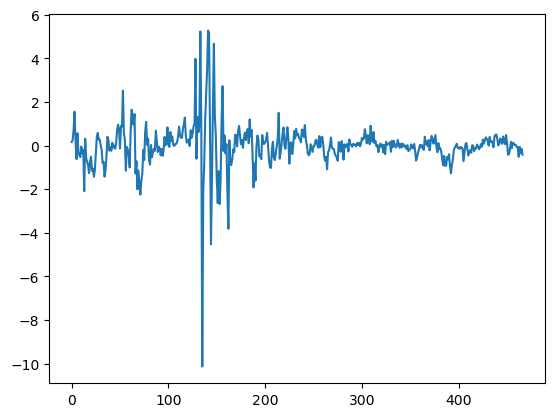

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(len(MP_shock)),MP_shock)